<a href="https://colab.research.google.com/github/meilona/Covid-19_Analysis/blob/master/Mei_Covid19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install -U -q PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Import libs

import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)
import matplotlib.pyplot as plt
import urllib, json
from urllib.request import Request, urlopen

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# USING KAWALCOVID19 (INDONESIA) SPREADSHEET DATA

In [5]:
downloaded = drive.CreateFile({'id':'18iJgZUypP0ot95_ptWgXCAb02XKP8_Oe'})
downloaded.GetContentFile('kawalcovid19_StatistikHarian.csv')
# Import dataset
dataset = pd.read_csv('kawalcovid19_StatistikHarian.csv')
dataset.shape

(122, 33)

## Preprocessing

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 33 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              122 non-null    object 
 1   Kasus baru                              122 non-null    object 
 2   Kasus Impor                             11 non-null     float64
 3   Kasus Lokal                             11 non-null     float64
 4   Total kasus                             122 non-null    object 
 5   Kasus aktif                             122 non-null    object 
 6   % kasus aktif                           122 non-null    object 
 7   Sembuh
(baru)                           122 non-null    object 
 8   Sembuh                                  122 non-null    object 
 9   Tingkat kesembuhan (seluruh kasus)      122 non-null    object 
 10  Tingkat kesembuhan (closed cases)       114 non-null    object

In [7]:
# columns that will be use
use = ['Unnamed: 0', 'Kasus baru', 'Total kasus', 'Sembuh\n(baru)', 'Sembuh', 'Meninggal\n(baru)', 'Meninggal\nDunia',
        'Jumlah orang diperiksa', 'Negatif', 'Positif \n(=C)', 'Positive rate Harian', 'Case Growth Rate']

# store used columns to dataframe
df_kawalcovid19 = dataset[use]

In [8]:
# Check df_kawalcovid19 data types
df_kawalcovid19.dtypes

# 10 Object and 2 int type

Unnamed: 0                object
Kasus baru                object
Total kasus               object
Sembuh\n(baru)            object
Sembuh                    object
Meninggal\n(baru)          int64
Meninggal\nDunia           int64
Jumlah orang diperiksa    object
Negatif                   object
Positif \n(=C)            object
Positive rate Harian      object
Case Growth Rate          object
dtype: object

In [9]:
# Rename columns name
columns_name = {'Unnamed: 0': 'Tanggal', 'Sembuh\n(baru)': 'Kasus Sembuh (baru)', 'Sembuh': 'Total Kasus Sembuh', 
                'Meninggal\n(baru)': 'Kasus Meninggal (baru)', 'Meninggal\nDunia': 'Total Kasus Meninggal', 
                'Negatif': 'Kasus Negatif', 'Positif \n(=C)': 'Kasus Positif'}
df_kawalcovid19 = df_kawalcovid19.rename(columns= columns_name)

# Confirm columns name changes has been saved
df_kawalcovid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Tanggal                 122 non-null    object
 1   Kasus baru              122 non-null    object
 2   Total kasus             122 non-null    object
 3   Kasus Sembuh (baru)     122 non-null    object
 4   Total Kasus Sembuh      122 non-null    object
 5   Kasus Meninggal (baru)  122 non-null    int64 
 6   Total Kasus Meninggal   122 non-null    int64 
 7   Jumlah orang diperiksa  122 non-null    object
 8   Kasus Negatif           122 non-null    object
 9   Kasus Positif           122 non-null    object
 10  Positive rate Harian    121 non-null    object
 11  Case Growth Rate        122 non-null    object
dtypes: int64(2), object(10)
memory usage: 11.6+ KB


In [10]:
# Convert object data type to float except column Tanggal
dtype_cols = ['Kasus baru', 'Total kasus', 'Kasus Sembuh (baru)', 'Total Kasus Sembuh',
              'Kasus Meninggal (baru)', 'Total Kasus Meninggal',
              'Jumlah orang diperiksa', 'Kasus Negatif', 'Kasus Positif']
df_kawalcovid19[dtype_cols] = df_kawalcovid19[dtype_cols].apply(pd.to_numeric, errors='coerce', axis=1)

# Convert data type (object contain precentage) to float
df_kawalcovid19['Positive rate Harian'] = df_kawalcovid19['Positive rate Harian'].str.rstrip('%').astype('float') / 100.0
df_kawalcovid19['Case Growth Rate'] = df_kawalcovid19['Case Growth Rate'].str.rstrip('%').astype('float') / 100.0

In [11]:
# See changes
df_kawalcovid19.dtypes

Tanggal                    object
Kasus baru                float64
Total kasus               float64
Kasus Sembuh (baru)       float64
Total Kasus Sembuh        float64
Kasus Meninggal (baru)    float64
Total Kasus Meninggal     float64
Jumlah orang diperiksa    float64
Kasus Negatif             float64
Kasus Positif             float64
Positive rate Harian      float64
Case Growth Rate          float64
dtype: object

In [12]:
# check is there any missing values
df_kawalcovid19.isnull().sum()

Tanggal                    0
Kasus baru                19
Total kasus               59
Kasus Sembuh (baru)        2
Total Kasus Sembuh        69
Kasus Meninggal (baru)     0
Total Kasus Meninggal      0
Jumlah orang diperiksa     2
Kasus Negatif              2
Kasus Positif             59
Positive rate Harian       1
Case Growth Rate           0
dtype: int64

In [13]:
# fill missing value with 0
df_kawalcovid19 = df_kawalcovid19.fillna(0)

# confirm all changes has been saved
df_kawalcovid19.isnull().sum()

Tanggal                   0
Kasus baru                0
Total kasus               0
Kasus Sembuh (baru)       0
Total Kasus Sembuh        0
Kasus Meninggal (baru)    0
Total Kasus Meninggal     0
Jumlah orang diperiksa    0
Kasus Negatif             0
Kasus Positif             0
Positive rate Harian      0
Case Growth Rate          0
dtype: int64

In [14]:
# Convert all data type to int except column Tanggal, Positive rate Harian , Case Growth Rate
df_kawalcovid19[dtype_cols] = df_kawalcovid19[dtype_cols].astype(int)

# confirm all changes has been saved
df_kawalcovid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Tanggal                 122 non-null    object 
 1   Kasus baru              122 non-null    int64  
 2   Total kasus             122 non-null    int64  
 3   Kasus Sembuh (baru)     122 non-null    int64  
 4   Total Kasus Sembuh      122 non-null    int64  
 5   Kasus Meninggal (baru)  122 non-null    int64  
 6   Total Kasus Meninggal   122 non-null    int64  
 7   Jumlah orang diperiksa  122 non-null    int64  
 8   Kasus Negatif           122 non-null    int64  
 9   Kasus Positif           122 non-null    int64  
 10  Positive rate Harian    122 non-null    float64
 11  Case Growth Rate        122 non-null    float64
dtypes: float64(2), int64(9), object(1)
memory usage: 11.6+ KB


In [15]:
# See first 10 data
df_kawalcovid19.head(10)

,Tanggal,Kasus baru,Total kasus,Kasus Sembuh (baru),Total Kasus Sembuh,Kasus Meninggal (baru),Total Kasus Meninggal,Jumlah orang diperiksa,Kasus Negatif,Kasus Positif,Positive rate Harian,Case Growth Rate
0,2 Mar,2,2,0,0,0,0,339,335,2,0.0000,0.0000
1,3 Mar,0,2,0,0,0,0,341,337,2,0.0000,0.0000
2,4 Mar,0,2,0,0,0,0,372,356,2,0.0000,0.0000
3,5 Mar,0,2,0,0,0,0,388,371,2,0.0000,0.0000
4,6 Mar,2,4,0,0,0,0,450,422,4,0.0377,1.0000
5,7 Mar,0,4,0,0,0,0,454,422,4,0.0000,0.0000
6,8 Mar,2,6,0,0,0,0,483,445,6,0.0800,0.5000
7,9 Mar,13,19,0,0,0,0,543,487,19,0.2364,2.1667
8,10 Mar,8,27,0,0,0,0,694,648,27,0.0473,0.4211
9,11 Mar,7,34,2,2,2,2,793,744,34,0.0680,0.2593


In [16]:
df_kawalcovid19.describe()

,Kasus baru,Total kasus,Kasus Sembuh (baru),Total Kasus Sembuh,Kasus Meninggal (baru),Total Kasus Meninggal,Jumlah orang diperiksa,Kasus Negatif,Kasus Positif,Positive rate Harian,Case Growth Rate
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,292.500000,11285.196721,193.131148,83.860656,24.049180,986.196721,124973.827869,109570.081967,11285.196721,0.169152,0.102814
std,277.624494,17686.670997,233.883384,199.720024,17.958562,876.428342,136691.058164,120770.064022,17686.670997,0.168586,0.239855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,9.500000,0.000000,10.000000,160.250000,6691.500000,5249.000000,0.000000,0.090675,0.025700
50%,253.500000,2.000000,84.500000,0.000000,21.000000,815.500000,70067.500000,60123.000000,2.000000,0.123400,0.033750
75%,482.750000,25633.750000,291.000000,30.000000,36.000000,1634.000000,213868.000000,188234.250000,25633.750000,0.192050,0.085025
max,993.000000,55092.000000,884.000000,960.000000,71.000000,2934.000000,465683.000000,410591.000000,55092.000000,1.000000,2.166700


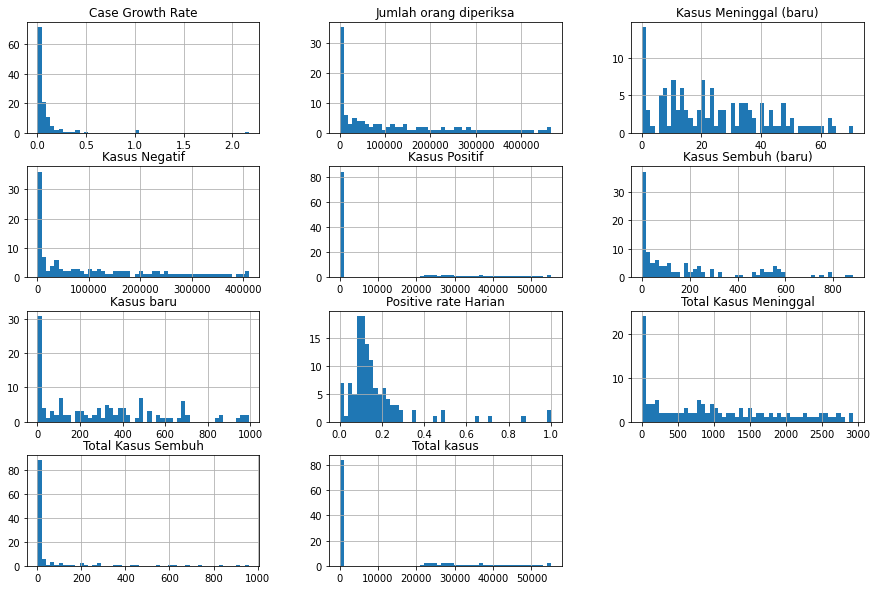

In [17]:
# lihat data features dari histogram
df_kawalcovid19.hist(bins=50, figsize=(15,10))
plt.show()

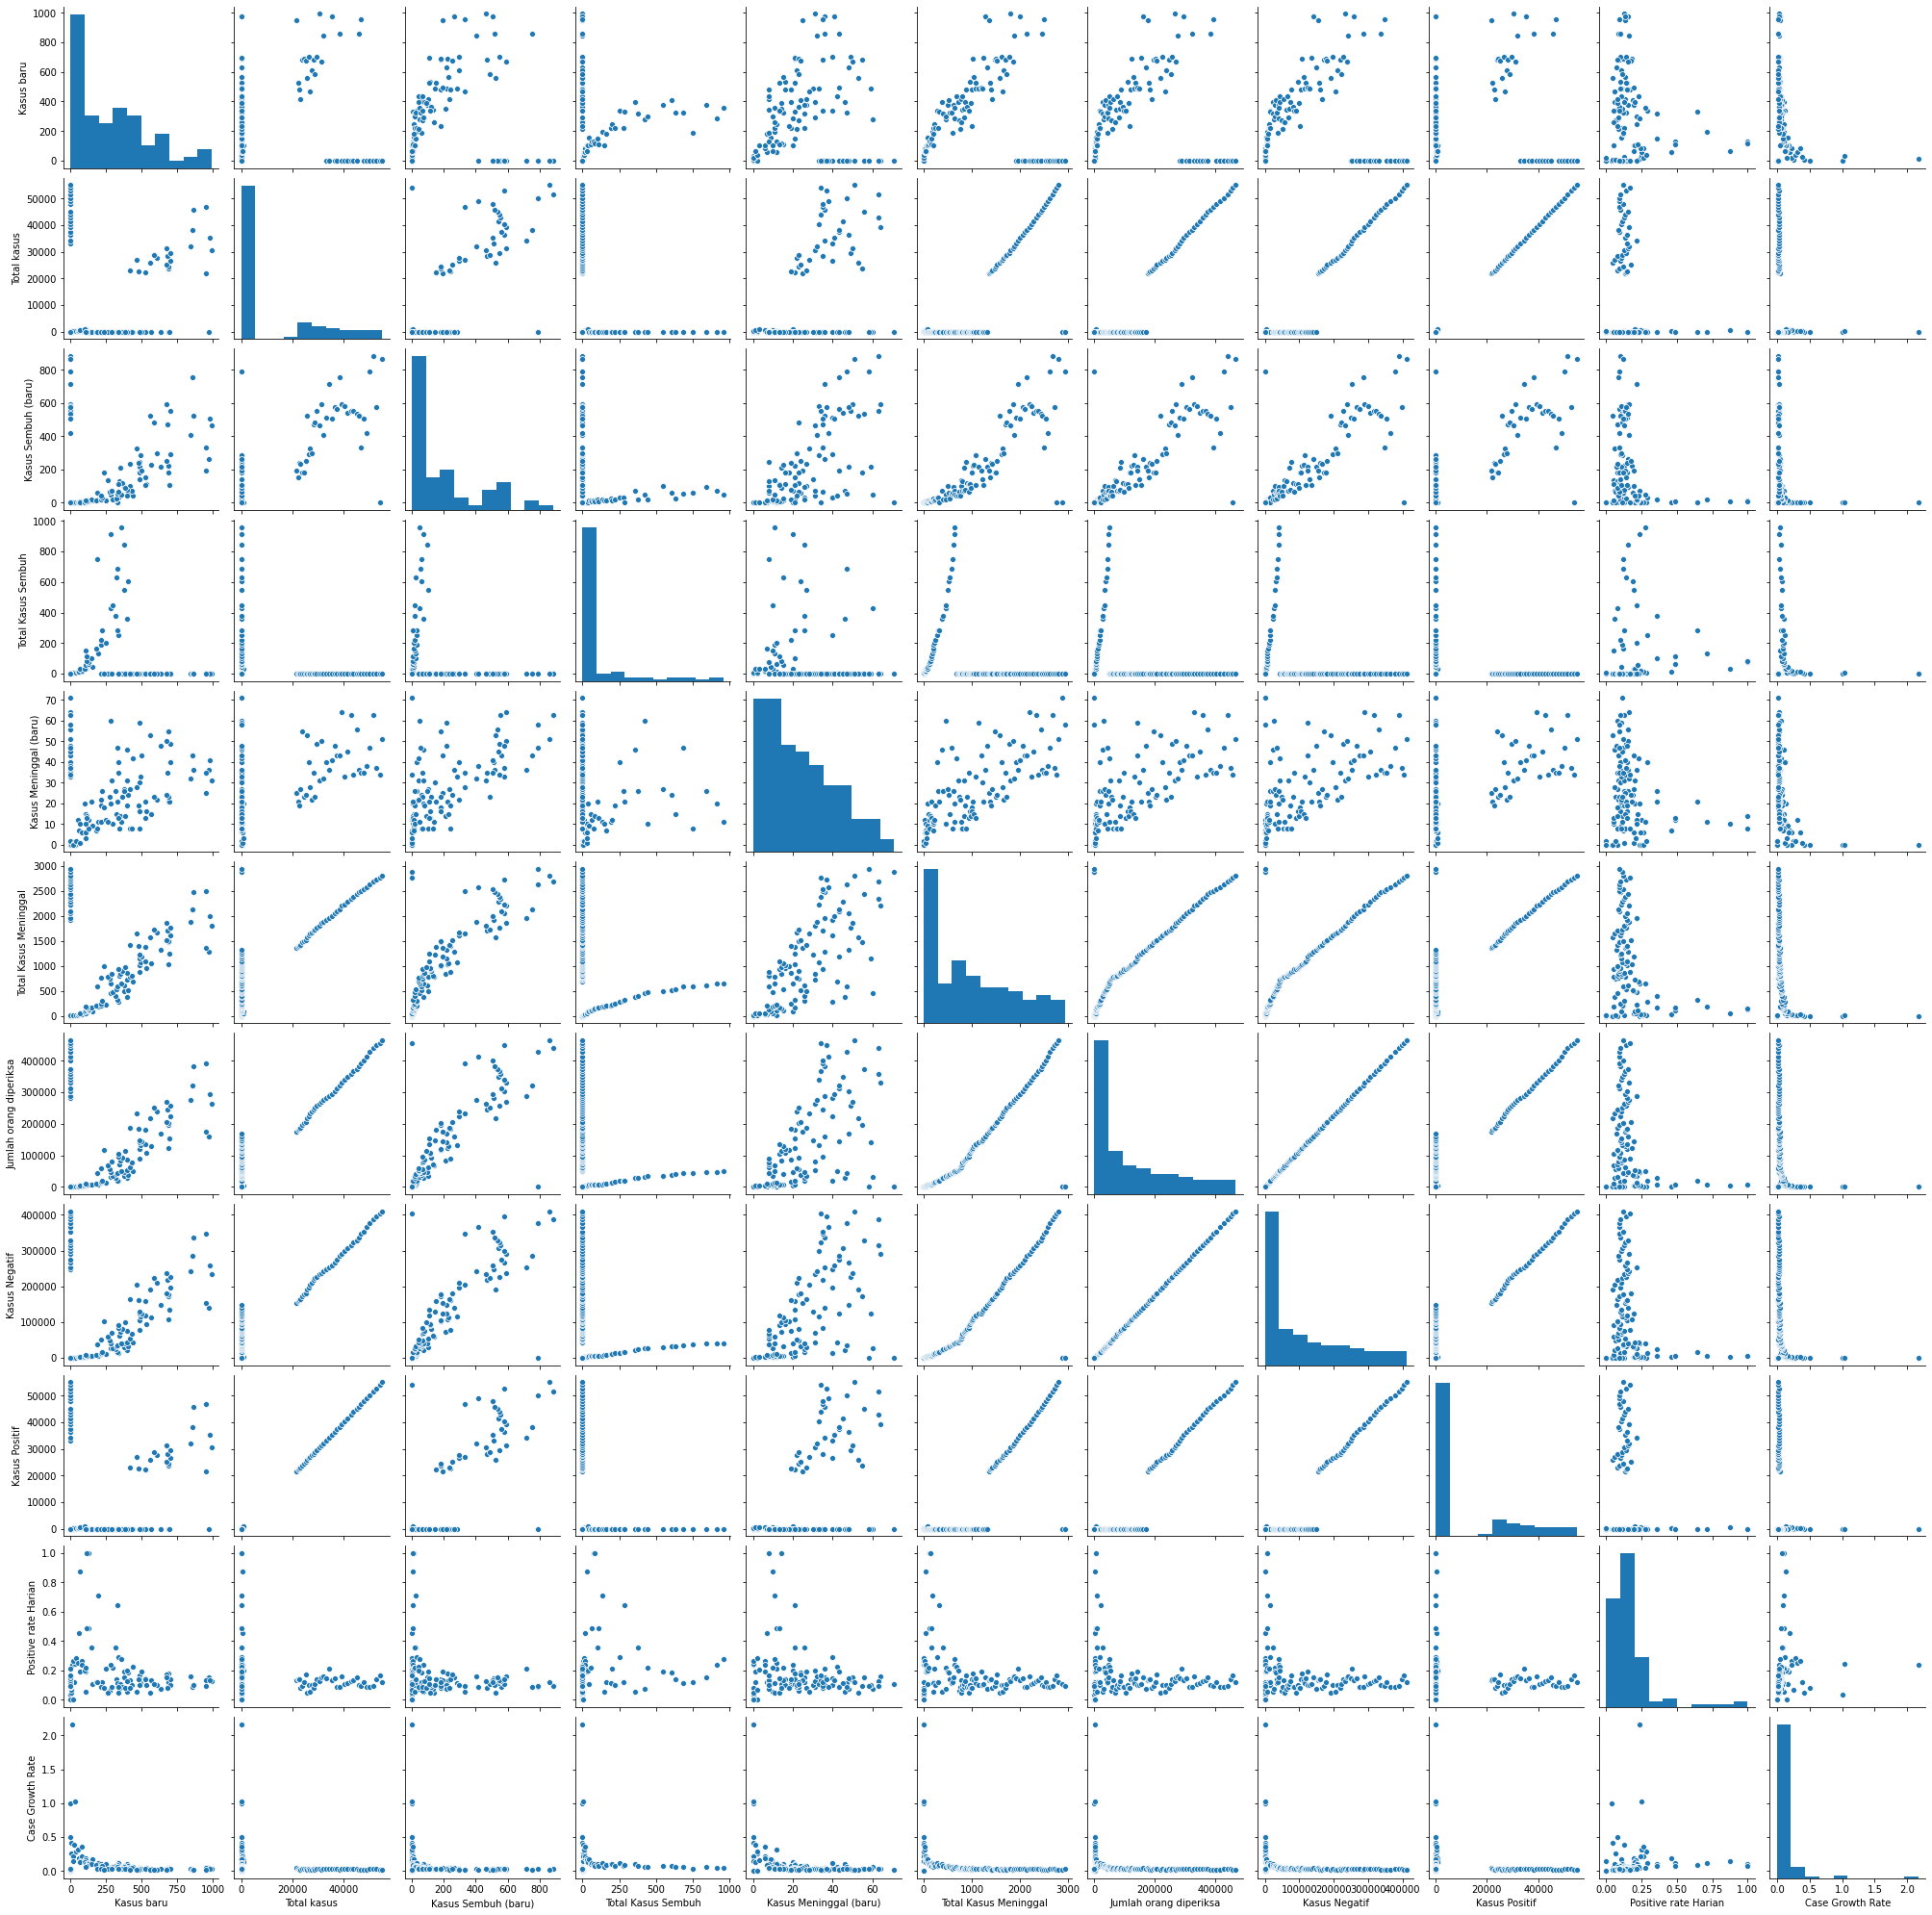

In [18]:
sns.pairplot(df_kawalcovid19)

In [19]:
df_kawalcovid19.corr()

,Kasus baru,Total kasus,Kasus Sembuh (baru),Total Kasus Sembuh,Kasus Meninggal (baru),Total Kasus Meninggal,Jumlah orang diperiksa,Kasus Negatif,Kasus Positif,Positive rate Harian,Case Growth Rate
Kasus baru,1.000000,0.084255,0.156680,0.000692,0.234449,0.239001,0.219702,0.218284,0.084255,-0.123822,-0.252230
Total kasus,0.084255,1.000000,0.826578,-0.269814,0.581471,0.846273,0.950670,0.951485,1.000000,-0.177266,-0.204994
Kasus Sembuh (baru),0.156680,0.826578,1.000000,-0.263558,0.683847,0.860190,0.852444,0.853061,0.826578,-0.226297,-0.254707
Total Kasus Sembuh,0.000692,-0.269814,-0.263558,1.000000,-0.037681,-0.252882,-0.284416,-0.286590,-0.269814,0.128590,-0.060840
Kasus Meninggal (baru),0.234449,0.581471,0.683847,-0.037681,1.000000,0.769490,0.643639,0.642722,0.581471,-0.158841,-0.337594
Total Kasus Meninggal,0.239001,0.846273,0.860190,-0.252882,0.769490,1.000000,0.907498,0.907222,0.846273,-0.268633,-0.336876
Jumlah orang diperiksa,0.219702,0.950670,0.852444,-0.284416,0.643639,0.907498,1.000000,0.999984,0.950670,-0.239221,-0.281391
Kasus Negatif,0.218284,0.951485,0.853061,-0.286590,0.642722,0.907222,0.999984,1.000000,0.951485,-0.239421,-0.279755
Kasus Positif,0.084255,1.000000,0.826578,-0.269814,0.581471,0.846273,0.950670,0.951485,1.000000,-0.177266,-0.204994
Positive rate Harian,-0.123822,-0.177266,-0.226297,0.128590,-0.158841,-0.268633,-0.239221,-0.239421,-0.177266,1.000000,0.095106


# USING KAWAL CORONA (PROVINCES) API DATA

In [20]:
# Indonesia Berdasarkan Provinsi from @kawalcovid19 API Link
url = "https://api.kawalcorona.com/indonesia/provinsi"

# request data, sesuaikan user-agent dengan browser yang dipakai
req = Request(url, headers={'User-Agent': 'Safari/13.0.5'})

# stored JSON format data
webpage = urlopen(req).read()
data_json = json.loads(webpage)

# Pretty Printing JSON string back
# print(json.dumps(data_json, indent = 4, sort_keys=True))

## PREPROCESSING

In [21]:
df = json_normalize(data_json)
df.shape

(34, 6)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   attributes.FID         34 non-null     int64 
 1   attributes.Kode_Provi  34 non-null     int64 
 2   attributes.Provinsi    34 non-null     object
 3   attributes.Kasus_Posi  34 non-null     int64 
 4   attributes.Kasus_Semb  34 non-null     int64 
 5   attributes.Kasus_Meni  34 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.7+ KB


In [23]:
# drop column FID
df = df.drop(columns = ['attributes.FID'])

# rename columns name
column_names = ['Kode Provinsi', 'Provinsi', 'Kasus Positive', 'Kasus Sembuh', 'Kasus Meninggal']
df.columns = column_names

In [24]:
df.describe()

,Kode Provinsi,Kasus Positive,Kasus Sembuh,Kasus Meninggal
count,34.000000,34.000000,34.000000,34.000000
mean,47.558824,1911.735294,881.323529,95.529412
std,26.501219,3271.078761,1567.614163,208.112329
min,11.000000,88.000000,42.000000,1.000000
25%,19.500000,213.500000,165.750000,6.500000
50%,51.500000,688.500000,299.500000,16.500000
75%,71.750000,1880.250000,943.750000,87.500000
max,94.000000,14321.000000,8036.000000,1053.000000


In [25]:
df.head()

,Kode Provinsi,Provinsi,Kasus Positive,Kasus Sembuh,Kasus Meninggal
0,35,Jawa Timur,14321,4996,1053
1,31,DKI Jakarta,12667,8036,649
2,73,Sulawesi Selatan,5974,2197,200
3,33,Jawa Tengah,4738,1567,215
4,32,Jawa Barat,3700,1718,178


In [26]:
# check is there any missing values
df.isnull().sum()

Kode Provinsi      0
Provinsi           0
Kasus Positive     0
Kasus Sembuh       0
Kasus Meninggal    0
dtype: int64

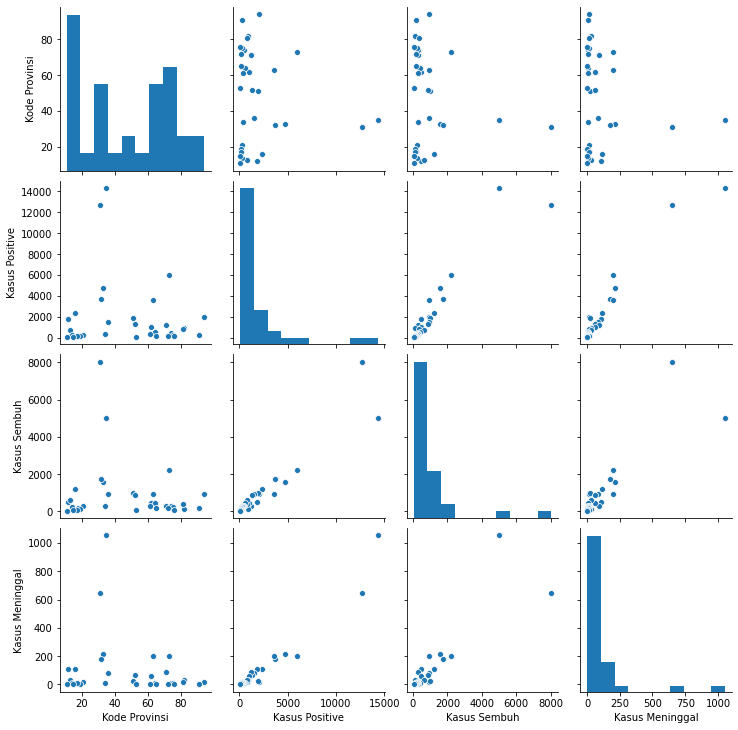

In [27]:
sns.pairplot(df)

In [28]:
df.corr()

,Kode Provinsi,Kasus Positive,Kasus Sembuh,Kasus Meninggal
Kode Provinsi,1.000000,-0.092928,-0.126524,-0.141976
Kasus Positive,-0.092928,1.000000,0.941473,0.966854
Kasus Sembuh,-0.126524,0.941473,1.000000,0.869323
Kasus Meninggal,-0.141976,0.966854,0.869323,1.000000


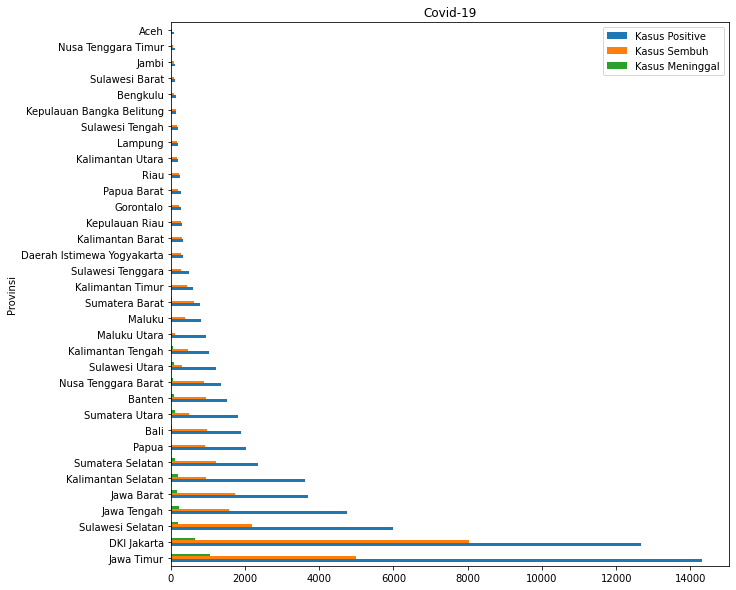

In [29]:
# A python dictionary
col = ["Kasus Positive","Kasus Sembuh", "Kasus Meninggal"]

# Draw a vertical bar chart
df.plot('Provinsi', col ,kind = 'barh', figsize=(10,10) , title="Covid-19")

## Clustering with Hierarchical Clustering

In [30]:
X = df.iloc[:, [2, 3, 4]].values

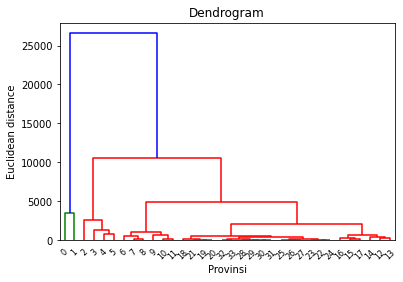

In [31]:
import scipy.cluster.hierarchy as sch
dendrogrm = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Provinsi')
plt.ylabel('Euclidean distance')
plt.show()

In [32]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

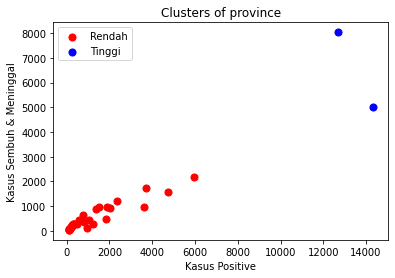

In [33]:
# Visualising the clusters
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 50, c = 'red', label = 'Rendah')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 50, c = 'blue', label = 'Tinggi')
plt.title('Clusters of province')
plt.xlabel('Kasus Positive')
plt.ylabel('Kasus Sembuh & Meninggal')
plt.legend()
plt.show()

In [34]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# USING DKI JAKARTA DATASET (MARCH-MAY)

In [35]:
downloaded = drive.CreateFile({'id':'1RD9Bri9L7Ab5sGNXuwRiHpRynsDGvcbJ'})
downloaded.GetContentFile('jkt_maret.csv')
# Import dataset
df_march = pd.read_csv('jkt_maret.csv')

In [36]:
downloaded = drive.CreateFile({'id':'1l5HHBLvFS01_9aB3YAgShtgXCahxS3UX'})
downloaded.GetContentFile('jkt_april.csv')
# Import dataset
df_april = pd.read_csv('jkt_april.csv')

In [37]:
downloaded = drive.CreateFile({'id':'1po9FT__CegqDlancPvjwR5YV3s_qfNof'})
downloaded.GetContentFile('jkt_mei.csv')
# Import dataset
df_mei = pd.read_csv('jkt_mei.csv')

In [38]:
# reference https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [df_march, df_april, df_mei]
df_jkt = pd.concat(frames)

In [39]:
df_jkt.shape

(276, 3)

In [40]:
df_jkt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 92
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tanggal   276 non-null    object
 1   diagnosa  276 non-null    object
 2   jumlah    276 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.6+ KB


In [41]:
# convert data type tanggal from object to datetime
df_jkt['tanggal'] = pd.to_datetime(df_jkt['tanggal'])
# confirm changes
df_jkt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 92
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   276 non-null    datetime64[ns]
 1   diagnosa  276 non-null    object        
 2   jumlah    276 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 8.6+ KB


In [42]:
#see data features
df_jkt.head()

,tanggal,diagnosa,jumlah
0,2020-03-01,Meninggal Harian,0
1,2020-03-01,Sembuh Harian,0
2,2020-03-01,Positif Harian,0
3,2020-03-02,Meninggal Harian,0
4,2020-03-02,Sembuh Harian,0


In [43]:
# check is there any missing values
df_jkt.isnull().sum()

tanggal     0
diagnosa    0
jumlah      0
dtype: int64

In [44]:
# function to make clean month list
def month_dataframe(df_month):
  for index, row in df_month.iterrows():
    if row['diagnosa'] == 'Meninggal Harian':
      date.append(row['tanggal'])
      death.append(row['jumlah'])
    elif row['diagnosa'] == 'Sembuh Harian':
      recovered.append(row['jumlah'])
    elif row['diagnosa'] == 'Positif Harian':
      positive.append(row['jumlah'])
  return date, death, recovered, positive;

# function to count cumulative list
def count_total(df_month):
  for index, row in df_month.iterrows():
    if index == 0:
      curr_death = row['Death']
      curr_recovered = row['Recovered']
      curr_cases = row['Positive']
    else:
      curr_death += row['Death']
      curr_recovered += row['Recovered']
      curr_cases = curr_cases + row['Positive'] - row['Recovered'] - row['Death']
    total_death.append(curr_death)
    total_recovered.append(curr_recovered)
    cases.append(curr_cases)
  return cases,total_death,total_recovered;

In [45]:
df_jkt.head()

,tanggal,diagnosa,jumlah
0,2020-03-01,Meninggal Harian,0
1,2020-03-01,Sembuh Harian,0
2,2020-03-01,Positif Harian,0
3,2020-03-02,Meninggal Harian,0
4,2020-03-02,Sembuh Harian,0


In [46]:
# Make list
date = []
death = []
recovered = []
positive = []
cases = []
total_death = []
total_recovered = []
# create march dataframe
month_dataframe(df_jkt)
month = {'Date': date, 'Death': death, 'Recovered': recovered, 'Positive': positive}
df_jkt = pd.DataFrame(month, columns = ['Date', 'Death', 'Recovered', 'Positive'])
#count susceptibles each rows
count_total(df_jkt)
#add new columns to dataframe
df_jkt['Cumulative Death Cases'] = total_death
df_jkt['Cumulative Recovered Cases'] = total_recovered
df_jkt['Current Total Positive'] = cases

In [47]:
df_jkt.head()

,Date,Death,Recovered,Positive,Cumulative Death Cases,Cumulative Recovered Cases,Current Total Positive
0,2020-03-01,0,0,0,0,0,0
1,2020-03-02,0,0,0,0,0,0
2,2020-03-03,1,0,3,1,0,2
3,2020-03-04,0,0,0,1,0,2
4,2020-03-05,2,0,4,3,0,4


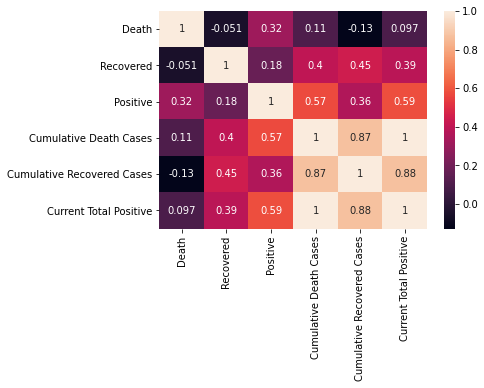

In [48]:
#see correlation in heatmap
sns.heatmap(df_jkt.corr(), annot=True)

In [49]:
# Function to make line graph
def line_graph(dataframe, mth):

  # multiple line plot
  plt.plot( 'Date', 'Death', data=dataframe, marker='', color='Red', linewidth=2, label="Death")
  plt.plot( 'Date', 'Recovered', data=dataframe, marker='', color='Green', linewidth=2, label="Recovered")
  plt.plot( 'Date', 'Positive', data=dataframe, marker='', color='Blue', linewidth=2, label="Positive")
    
  # naming the x axis 
  plt.xlabel('Date')
  plt.xticks(rotation=30)
  # naming the y axis 
  plt.ylabel('Total Cases', ha='center') 
  # show label
  plt.legend()
  plt.gcf().set_size_inches(10, 5)
    
  # giving a title to my graph 
  plt.title('Data Visualization of COVID-19 IN DKI Jakarta each day on '+ mth) 

  # function to show the plot 
  plt.show()

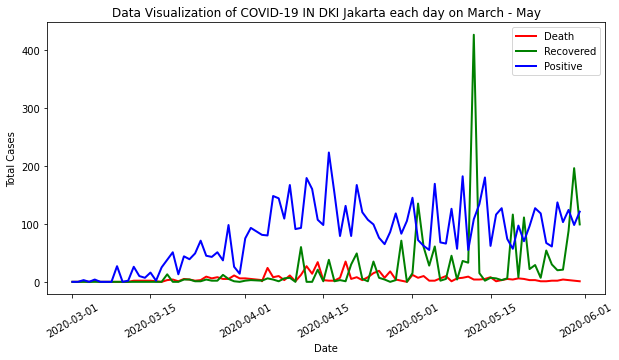

In [50]:
line_graph(df_jkt, 'March - May')